In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s3e9/sample_submission.csv
/kaggle/input/playground-series-s3e9/train.csv
/kaggle/input/playground-series-s3e9/test.csv


In [2]:
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
from lightgbm import LGBMRegressor
from lightgbm import log_evaluation, early_stopping
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import KFold, cross_val_score, StratifiedKFold, KFold
from sklearn.metrics import mean_squared_error, roc_curve, auc, accuracy_score, confusion_matrix, f1_score
from sklearn.model_selection import train_test_split
import optuna
from optuna.samplers import TPESampler

In [3]:
train = pd.read_csv("/kaggle/input/playground-series-s3e9/train.csv")
test = pd.read_csv("/kaggle/input/playground-series-s3e9/test.csv")

In [4]:
train.head(5)

,id,CementComponent,BlastFurnaceSlag,FlyAshComponent,WaterComponent,SuperplasticizerComponent,CoarseAggregateComponent,FineAggregateComponent,AgeInDays,Strength
0,0,525.0,0.0,0.0,186.0,0.0,1125.0,613.0,3,10.38
1,1,143.0,169.0,143.0,191.0,8.0,967.0,643.0,28,23.52
2,2,289.0,134.7,0.0,185.7,0.0,1075.0,795.3,28,36.96
3,3,304.0,76.0,0.0,228.0,0.0,932.0,670.0,365,39.05
4,4,157.0,236.0,0.0,192.0,0.0,935.4,781.2,90,74.19


In [5]:
len(train.columns)

10

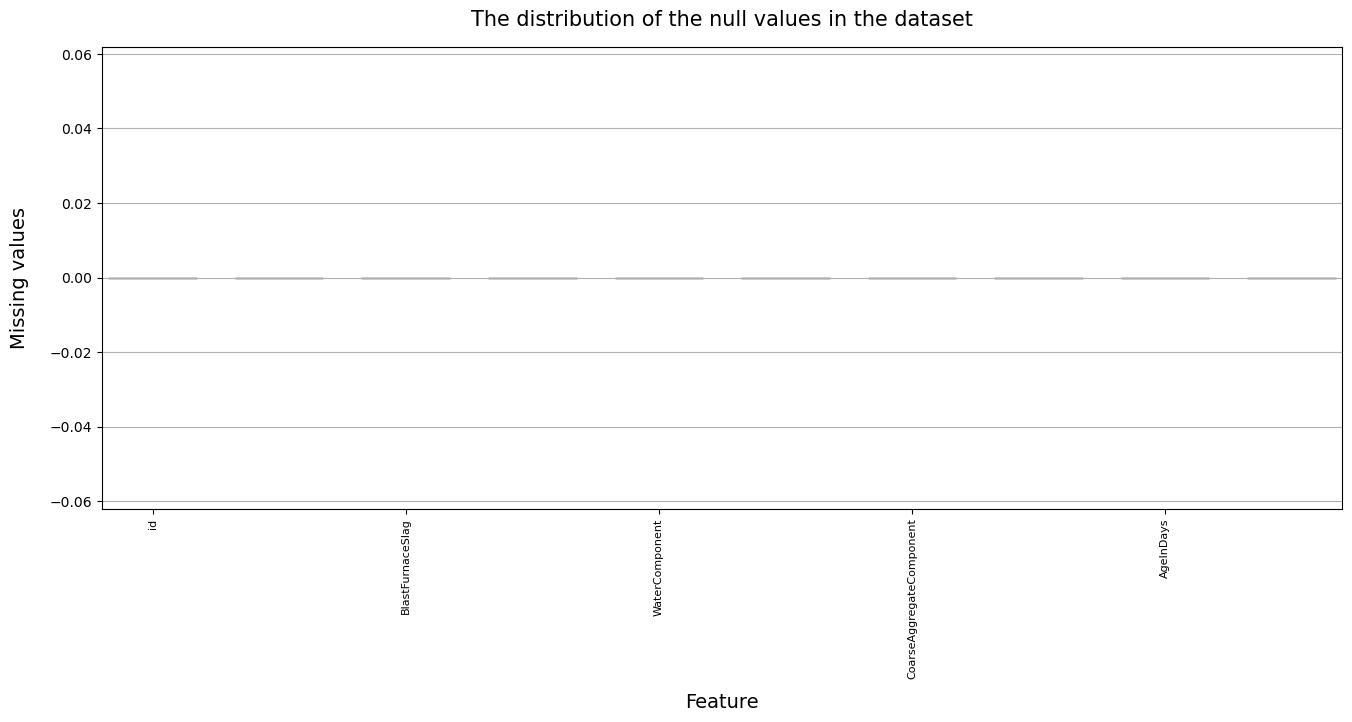

In [6]:
# Plotting figures for null values.
fig, ax = plt.subplots(figsize = (16, 6))

bars = ax.bar(train.isna().sum().index,
             train.isna().sum().values,
             color = "lightskyblue",
             edgecolor = "black",
             width = 0.7)

ax.set_title("The distribution of the null values in the dataset", fontsize = 15, pad = 15)
ax.set_ylabel("Missing values", fontsize = 14, labelpad = 15)
ax.set_xlabel("Feature", fontsize = 14, labelpad = 10)
ax.set_xticks([x if i % 2 == 0 else "" for i, x in enumerate(train.columns.values)])
ax.tick_params(axis = "x", rotation = 90, labelsize = 8)
ax.margins(0.005, 0.12)
ax.grid(axis = "y")

plt.show();

### Data Preprocessing

In [7]:
features = [x for x in train.columns.values if x[0] == "f"]

for feature in features:
    train[feature].fillna(np.mean(train[feature]), inplace = True)
    test[feature].fillna(np.mean(test[feature]), inplace = True)

In [8]:
from copy import deepcopy
Scaler = StandardScaler()
train_s = deepcopy(train)
test_s = deepcopy(test)

for feature in features:
    train_s[feature] = Scaler.fit_transform(np.array(train[feature]), reshape(-1, 1))
    test_s[feature] = Scaler.fit_transform(np.array(test[feature]), reshape(-1, 1))

In [9]:
X, y = train.drop(["id", "Strength"], axis = 1), train.Strength

In [10]:
X.columns

Index(['CementComponent', 'BlastFurnaceSlag', 'FlyAshComponent',
       'WaterComponent', 'SuperplasticizerComponent',
       'CoarseAggregateComponent', 'FineAggregateComponent', 'AgeInDays'],
      dtype='object')

In [11]:
def iqr_capping(df, cols, factor, if_upper=True, if_lower=True):
    for col in cols:
        df_outliers = df.copy()
        df_outliers[col] = sorted(df_outliers[col])
        Q1 = df_outliers[col].quantile(0.25)
        Q3 = df_outliers[col].quantile(0.75)

#         if Q3 == 0.0 or Q1 == 0.0:


#             # Q1 =0 or Q3 = 0 means that there are almost or more than 0 values in perticular column.
#             # the bais is so much and lets categorize those values as 0 and 1. 0 = values is zero, 1 = value is not zero
#             df[col] = np.where(df[col] == 0.0, 0, 1)
#             df[col] = np.where(df[col] == 0, 0, 1)
#             df[col] = df[col].astype('int64')

        IQR = Q3 - Q1

        lower_bound = Q1 - (factor*IQR)
        upper_bound = Q3 + (factor*IQR)
        
        if if_upper:
            df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])
        if if_lower:
            df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])  
    return df

def outliers(data, col_list, if_upper=True, if_lower=True):

    data_cap = data.copy()

    new_data = iqr_capping(data_cap, col_list, 1.5, if_upper, if_lower)
    return new_data

In [12]:
def feature_engineering(df):
    df = outliers(df, ['AgeInDays'], True, False)
#     df['Water_Cement'] = df['WaterComponent'] / df['CementComponent'] # delete
    df['total'] = df['CementComponent'] + df['BlastFurnaceSlag'] + df['FlyAshComponent'] + df['WaterComponent'] + df['SuperplasticizerComponent'] + df['CoarseAggregateComponent'] + df['FineAggregateComponent']
    df['Coarse_Fine'] = df['CoarseAggregateComponent'] / df['FineAggregateComponent']
    df['Aggregate'] = df['CoarseAggregateComponent'] + df['FineAggregateComponent']
#     df['Aggregate_Cement'] = df['Aggregate'] / df['CementComponent'] # delete
    df['Slag_Cement'] = df['BlastFurnaceSlag'] / df['CementComponent']
    df['Ash_Cement'] = df['FlyAshComponent'] / df['CementComponent']
#     df['Plastic_Cement'] = df['SuperplasticizerComponent'] / df['CementComponent']
    df['Age_Water'] = df['AgeInDays'] / df['WaterComponent']
    df['Cem_pct'] = df['CementComponent'] / df['total']
    df['Blast_pct'] = df['BlastFurnaceSlag'] / df['total']
    df['Ash_pct'] = df['FlyAshComponent'] / df['total']
    df['water_pct'] = df['WaterComponent'] / df['total']
    df['plas_pct'] = df['SuperplasticizerComponent'] / df['total']
    df['super_water'] = df['SuperplasticizerComponent'] / df['WaterComponent']
#     df['water_pct_final'] = df['water_pct'] / (1 - df['plas_pct'])  # increase the rmse
#     cols_to_drop = ['FlyAshComponent', 'BlastFurnaceSlag']
#     df['if_Blast'] = df['BlastFurnaceSlag'] != 0
#     df['if_Ash'] = df['FlyAshComponent'] != 0
#     return df.drop(labels=cols_to_drop, axis=1)
    return df

In [13]:
X = feature_engineering(X)
X.columns

Index(['CementComponent', 'BlastFurnaceSlag', 'FlyAshComponent',
       'WaterComponent', 'SuperplasticizerComponent',
       'CoarseAggregateComponent', 'FineAggregateComponent', 'AgeInDays',
       'total', 'Coarse_Fine', 'Aggregate', 'Slag_Cement', 'Ash_Cement',
       'Age_Water', 'Cem_pct', 'Blast_pct', 'Ash_pct', 'water_pct', 'plas_pct',
       'super_water'],
      dtype='object')

In [14]:
def lgb_estimation(trial,data=X,target=y):
    x_train, x_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25,random_state=661)
    params = {
        'reg_alpha' : trial.suggest_float('alpha', 0, 10.0),
        'reg_lambda' : trial.suggest_float('lambda', 0, 10.0),
        'num_leaves' : trial.suggest_int('num_leaves' , 20 , 70),
        'learning_rate' : trial.suggest_float('learning_rate' , 0.008 , 0.04),
        'max_depth' : trial.suggest_int('max_depth', 5 , 15),
        'n_estimators' : trial.suggest_int('n_estimators', 200 , 2000),
        'min_child_weight': trial.suggest_float('min_child_weight', 1e-4, 100),
        'subsample': trial.suggest_float('subsample', 0.5, 0.9, step=0.05), 
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 0.9, step=0.05),
        'min_child_samples' : trial.suggest_int('min_child_samples', 10, 100),
        'metric' : 'l2_root',
        'subsample_freq' : 1,
#         'device_type' : 'gpu',
    }

    model = LGBMRegressor(**params, random_state=661, n_jobs=-1)
    model.fit(x_train, y_train,eval_set=[(x_valid,y_valid)], callbacks=[log_evaluation(0), early_stopping(stopping_rounds=100)])
    
    preds = model.predict(x_valid)
    # for classification
#     fpr, tpr, thresholds = roc_curve(y_valid, preds, pos_label=1)
    
#     return auc(fpr, tpr)
    # for regression
    return np.sqrt(mean_squared_error(y_valid, preds))


def train_lgb(mins):
    train_time = 1 * mins * 60
    study_lgb = optuna.create_study(direction='minimize', sampler=TPESampler(), study_name='LGBRegressor')
    study_lgb.optimize(lgb_estimation, timeout=train_time)

    print('Number of finished trials: ', len(study_lgb.trials))
    print('Best trial:')
    trial_lgb = study_lgb.best_trial

    print('\tValue: {}'.format(trial_lgb.value))
    print('\tParams: ')
    for key, value in trial_lgb.params.items():
        print('\t\t{}: {}'.format(key, value))
    print(trial_lgb.params)
    return trial_lgb.params


In [15]:
def xgb_estimation(trial,data=X,target=y):
    
    x_train, x_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25,random_state=661)
    param = {
        'lambda': trial.suggest_float('lambda', 1, 100),
        'alpha': trial.suggest_float('alpha', 1, 100),
        'gamma': trial.suggest_float('gamma', 1e-3, 1e4),
        'n_estimators': trial.suggest_int('n_estimators', 400, 4000, 400),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.2, 0.9, step=0.05),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.2, 0.9, step=0.05),
        'subsample': trial.suggest_float('subsample', 0.5, 0.9, step=0.05),
        'eta': trial.suggest_float('eta', 0.007,0.020),
        'n_estimators': trial.suggest_int("n_estimators",400,4000,400),
        'max_depth': trial.suggest_int('max_depth', 3,15,1),
        'min_child_weight': trial.suggest_float('min_child_weight', 1, 1000),
    }
    model = xgb.XGBModel(
        objective='reg:squarederror',
        tree_method='gpu_hist',   #which tree to chose: https://xgboost.readthedocs.io/en/latest/treemethod.html
        predictor='gpu_predictor',
        n_jobs=-1,
        eval_metric='rmse',
        **param
    ) 
    
    model.fit(x_train, y_train,
            eval_set=[(x_valid, y_valid)], 
            verbose=False)
    
    preds = model.predict(x_valid)
    
#     for classification, use auc
#     fpr, tpr, thresholds = roc_curve(y_valid, preds, pos_label=1)
    
#     return auc(fpr, tpr)

#     for regression, use rmse
    return np.sqrt(mean_squared_error(y_valid, preds))

def train_xgb(mins):
    train_time = 1 * mins * 60
    study_xgb = optuna.create_study(direction='minimize', sampler=TPESampler(), study_name='XGBRegressor')
    study_xgb.optimize(xgb_estimation, timeout=train_time)

    print('Number of finished trials: ', len(study_xgb.trials))
    print('Best trial:')
    trial_xgb = study_xgb.best_trial

    print('\tValue: {}'.format(trial_xgb.value))
    print('\tParams: ')
    for key, value in trial_xgb.params.items():
        print('\t\t{}: {}'.format(key, value))
    print(trial_xgb.params)
    return trial_xgb.params

In [16]:
# v0  no feature engineering
# lgb_params = {'alpha': 2.789391411903337, 'lambda': 0.7663779968619002, 'num_leaves': 58, 'learning_rate': 0.013804977701340305, 'max_depth': 4, 'n_estimators': 844, 'min_child_weight': 78.04268435027113, 'subsample': 0.9, 'colsample_bytree': 0.8, 'min_child_samples': 21}
# v1 v11_feature_engineering  rmse: 11.7155509714386  score: 11.74218
# lgb_params = {'alpha': 2.482984175954966, 'lambda': 2.163680191436034, 'num_leaves': 56, 'learning_rate': 0.02822666835102667, 'max_depth': 3, 'n_estimators': 359, 'min_child_weight': 49.369998334202066, 'subsample': 0.65, 'colsample_bytree': 0.4, 'min_child_samples': 57}
# v2 v13_feature_engineering(water_pct_final)  rmse: 11.723014030837183 score: 11.76459 
# lgb_params = {'alpha': 5.087555021928418, 'lambda': 0.45889733429019824, 'num_leaves': 45, 'learning_rate': 0.008991154466741197, 'max_depth': 3, 'n_estimators': 1660, 'min_child_weight': 72.79320449477417, 'subsample': 0.55, 'colsample_bytree': 0.6, 'min_child_samples': 44}
# v3 v13 feature_engineering(between_features maybe overfit) rmse: 11.689622668785656
# lgb_params = {'alpha': 3.7491051214928586, 'lambda': 9.754251878506999, 'num_leaves': 57, 'learning_rate': 0.035500366144771985, 'max_depth': 3, 'n_estimators': 406, 'min_child_weight': 62.55355297232509, 'subsample': 0.55, 'colsample_bytree': 0.25, 'min_child_samples': 56}
# v4 v15 rmse: 11.743142650166241
# lgb_params = {'alpha': 2.3374745222411537, 'lambda': 9.410472458752276, 'num_leaves': 66, 'learning_rate': 0.01096104650270119, 'max_depth': 3, 'n_estimators': 1403, 'min_child_weight': 95.18631980453459, 'subsample': 0.65, 'colsample_bytree': 0.35, 'min_child_samples': 41}
# v5 v18 rmse: 11.713244127279372 score: 11.8083 
# lgb_params = {'alpha': 8.529063913048997, 'lambda': 5.806774064890355, 'num_leaves': 46, 'learning_rate': 0.01037248111645384, 'max_depth': 3, 'n_estimators': 1651, 'min_child_weight': 0.15610884660612356, 'subsample': 0.55, 'colsample_bytree': 0.6, 'min_child_samples': 55}
# v6 v19 rmse: 11.724836556076982 score: 11.79582 
# lgb_params = {'alpha': 4.736526010858983, 'lambda': 5.813149749773689, 'num_leaves': 56, 'learning_rate': 0.022416568056289506, 'max_depth': 3, 'n_estimators': 405, 'min_child_weight': 34.408068961125664, 'subsample': 0.75, 'colsample_bytree': 0.5, 'min_child_samples': 37}
# v7 v17 rmse: 11.71192877427309
# lgb_params = {'alpha': 9.392288159151912, 'lambda': 1.3108059133034582, 'num_leaves': 64, 'learning_rate': 0.03006802262552128, 'max_depth': 3, 'n_estimators': 374, 'min_child_weight': 20.506669629607376, 'subsample': 0.5, 'colsample_bytree': 0.45000000000000007, 'min_child_samples': 64}
# v18 v22 rmse: 11.71542344747918
# lgb_params = {'alpha': 9.358818376720071, 'lambda': 0.03175652688643393, 'num_leaves': 45, 'learning_rate': 0.013760720362070742, 'max_depth': 3, 'n_estimators': 1853, 'min_child_weight': 82.27660904356708, 'subsample': 0.7, 'colsample_bytree': 0.4, 'min_child_samples': 42}
# v24 rmse: 11.707863378485195 score: 11.77161
# lgb_params = {'alpha': 9.424376346434014, 'lambda': 4.754657333356563, 'num_leaves': 60, 'learning_rate': 0.03996759455689611, 'max_depth': 3, 'n_estimators': 432, 'min_child_weight': 45.42006633303572, 'subsample': 0.6, 'colsample_bytree': 0.6, 'min_child_samples': 28}
# v26 rmse: 11.7027834614787
# lgb_params = {'alpha': 0.801121692934334, 'lambda': 0.8007530708651776, 'num_leaves': 27, 'learning_rate': 0.01910783502628706, 'max_depth': 3, 'n_estimators': 1805, 'min_child_weight': 62.372711490923514, 'subsample': 0.55, 'colsample_bytree': 0.7500000000000001, 'min_child_samples': 23}
# v27 rmse: 11.735
lgb_params = {'alpha': 1.420836449268614, 'lambda': 3.2271509145180466, 'num_leaves': 65, 'learning_rate': 0.016151838086801797, 'max_depth': 5, 'n_estimators': 1912, 'min_child_weight': 90.18039116815461, 'subsample': 0.7, 'colsample_bytree': 0.6, 'min_child_samples': 27}

# fit the LGBM model.
model_lgb = LGBMRegressor(**lgb_params)
X_train, X_validate, y_train, y_validate = train_test_split(X, y, test_size=0.25,random_state=661)
model_lgb.fit(
    X_train, 
    y_train, 
    eval_set=[(X_validate, y_validate)], 
    callbacks=[log_evaluation(0), early_stopping(stopping_rounds=100)]
)

[LightGBM] [Warning] lambda_l2 is set with lambda=3.2271509145180466, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.2271509145180466
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[387]	valid_0's l2: 139.019


LGBMRegressor(alpha=1.420836449268614, colsample_bytree=0.6,
              lambda=3.2271509145180466, learning_rate=0.016151838086801797,
              max_depth=5, min_child_samples=27,
              min_child_weight=90.18039116815461, n_estimators=1912,
              num_leaves=65, subsample=0.7)

## Model Training

### LightGBM

In [17]:
# fit the xgboost model.
# v0 no feature engineering
# xgb_params = {'lambda': 77.49962549883482, 'alpha': 82.18225259625488, 'gamma': 15.931349867898405, 'n_estimators': 800, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.8500000000000001, 'subsample': 0.8, 'eta': 0.012725247852891981, 'max_depth': 6, 'min_child_weight': 68.89402022666454}
# v1 feature engeneering all  rmse: 11.715139358976572  public score: 11.79273
# xgb_params = {'lambda': 32.177299907723544, 'alpha': 20.217011924089984, 'gamma': 491.07449304092654, 'n_estimators': 1600, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.30000000000000004, 'subsample': 0.6, 'eta': 0.01955176865058411, 'max_depth': 15, 'min_child_weight': 34.07594093214089}
# v2 community feature engineering rmse: 11.694449478177797  public score: 11.82519
# xgb_params = {'lambda': 7.686305623499616, 'alpha': 77.65142691683158, 'gamma': 388.4159370385702, 'n_estimators': 1600, 'colsample_bytree': 0.65, 'colsample_bylevel': 0.8, 'subsample': 0.55, 'eta': 0.018884247339333155, 'max_depth': 11, 'min_child_weight': 23.745743912778618}
# v3 v9_feature_engineering rmse: 11.734282077275951  
# xgb_params = {'lambda': 15.893228226420925, 'alpha': 94.95204503532351, 'gamma': 381.39486886168913, 'n_estimators': 1200, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.9, 'subsample': 0.65, 'eta': 0.017645060611547, 'max_depth': 15, 'min_child_weight': 41.410481195227675}
# v4 v12_feature_engineering (water_pct_final) rmse: 11.731640479150283
# xgb_params = {'lambda': 34.85527435683103, 'alpha': 95.29159461807336, 'gamma': 478.52009376310014, 'n_estimators': 2000, 'colsample_bytree': 0.75, 'colsample_bylevel': 0.75, 'subsample': 0.5, 'eta': 0.019031153557641307, 'max_depth': 12, 'min_child_weight': 17.61448760776969}
# v5 v15 rmse: 11.73854631800215
# xgb_params = {'lambda': 98.05815450876177, 'alpha': 46.38007332681764, 'gamma': 350.83727095786116, 'n_estimators': 4000, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.6000000000000001, 'subsample': 0.8500000000000001, 'eta': 0.008556361136498328, 'max_depth': 11, 'min_child_weight': 40.180165994809514}
#v6 v17 rmse: 11.730942170898608
# xgb_params = {'lambda': 52.69991876135283, 'alpha': 84.74832566934813, 'gamma': 305.8186771906626, 'n_estimators': 1600, 'colsample_bytree': 0.75, 'colsample_bylevel': 0.7, 'subsample': 0.5, 'eta': 0.01033984835688292, 'max_depth': 12, 'min_child_weight': 53.15059624182796}
# v7 v19 rmse: 11.7228519218682 
# xgb_params = {'lambda': 7.977216542047289, 'alpha': 96.00256121054734, 'gamma': 424.7246280499904, 'n_estimators': 4000, 'colsample_bytree': 0.55, 'colsample_bylevel': 0.7, 'subsample': 0.55, 'eta': 0.014976260190252628, 'max_depth': 7, 'min_child_weight': 11.31803342543569}
# v8 v20 rmse: 11.732066771740824
# xgb_params = {'lambda': 68.19771188033513, 'alpha': 5.585692610410164, 'gamma': 321.8943596982266, 'n_estimators': 1200, 'colsample_bytree': 0.55, 'colsample_bylevel': 0.65, 'subsample': 0.8, 'eta': 0.017995572196639494, 'max_depth': 3, 'min_child_weight': 28.520534406461202}
# v9 v23 rmse: 11.732104374090634
# xgb_params = {'lambda': 75.617892952552, 'alpha': 98.40697023717092, 'gamma': 328.9884692345956, 'n_estimators': 3200, 'colsample_bytree': 0.55, 'colsample_bylevel': 0.8500000000000001, 'subsample': 0.7, 'eta': 0.00741171762054712, 'max_depth': 15, 'min_child_weight': 50.42121145748578}
# v10 v24 rmse: 11.711545919979155
# xgb_params = {'lambda': 83.12498282712812, 'alpha': 48.48906979813305, 'gamma': 345.75902869986123, 'n_estimators': 1200, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.35000000000000003, 'subsample': 0.6, 'eta': 0.014800264592487837, 'max_depth': 12, 'min_child_weight': 33.390681675651194}
# v24 rmse: 11.71000255332253 score: 11.80
# xgb_params = {'lambda': 40.12006385309597, 'alpha': 52.351701471931115, 'gamma': 585.9269359658983, 'n_estimators': 2000, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.4, 'subsample': 0.65, 'eta': 0.016884486184806917, 'max_depth': 12, 'min_child_weight': 19.001287767449224}
# v27 rmse: 11.714141795087102
xgb_params = {'lambda': 87.37999792744466, 'alpha': 66.7857360405316, 'gamma': 291.373769438789, 'n_estimators': 3600, 'colsample_bytree': 0.65, 'colsample_bylevel': 0.5, 'subsample': 0.7, 'eta': 0.01478860713528666, 'max_depth': 10, 'min_child_weight': 27.45479074069285}

model_xgb = xgb.XGBModel(
        objective='reg:squarederror',
        tree_method='gpu_hist',   #which tree to chose: https://xgboost.readthedocs.io/en/latest/treemethod.html
        predictor='gpu_predictor',
        n_jobs=-1,
        eval_metric='rmse',
        **xgb_params
    )
X_train, X_validate, y_train, y_validate = train_test_split(X, y, test_size=0.25,random_state=661)
model_xgb.fit(
    X_train, 
    y_train, 
    eval_set=[(X_validate, y_validate)], 
    verbose=False
)

XGBModel(alpha=66.7857360405316, base_score=0.5, booster='gbtree',
         colsample_bylevel=0.5, colsample_bynode=1, colsample_bytree=0.65,
         eta=0.01478860713528666, eval_metric='rmse', gamma=291.373769438789,
         gpu_id=0, grow_policy='depthwise', interaction_constraints='',
         lambda=87.37999792744466, learning_rate=0.0147886071, max_bin=256,
         max_cat_to_onehot=4, max_delta_step=0, max_depth=10, max_leaves=0,
         min_child_weight=27.45479074069285, monotone_constraints='()',
         n_estimators=3600, n_jobs=-1, num_parallel_tree=1,
         objective='reg:squarederror', predictor='gpu_predictor',
         random_state=0, reg_alpha=66.7857361, reg_lambda=87.3799973,
         sampling_method='uniform', ...)

In [18]:
# generate the predict value
pred_lgb = model_lgb.predict(feature_engineering(test.drop(['id'], axis=1)))
pred_xgb = model_xgb.predict(feature_engineering(test.drop(['id'], axis=1)))

In [19]:
feature_importances = pd.DataFrame({'Feature': model_lgb.feature_name_, 'Importance': model_lgb.feature_importances_})
feature_importances

,Feature,Importance
0,CementComponent,323
1,BlastFurnaceSlag,127
2,FlyAshComponent,64
3,WaterComponent,251
4,SuperplasticizerComponent,142
5,CoarseAggregateComponent,462
6,FineAggregateComponent,381
7,AgeInDays,249
8,total,619
9,Coarse_Fine,385


In [20]:
test_df = feature_engineering(test.drop(['id'], axis=1))
kfold = KFold(n_splits=10, shuffle=True, random_state=0)
pred_xgb = np.zeros(test_df.shape[0])
pred_lgb = np.zeros(test_df.shape[0])
rmse_xgb=[] 
rmse_lgb=[]
rmse = []# list contains rmse for each fold
n=0

for i, (train_index, valid_index) in enumerate(kfold.split(X, y)):
    x_train, y_train = X.iloc[train_index], y.iloc[train_index]
    x_valid, y_valid = X.loc[valid_index], y.iloc[valid_index]
    
    # XGBoost regressor
    model_xgb = xgb.XGBModel(
        objective='reg:squarederror',
        tree_method='gpu_hist',
        predictor='gpu_predictor',
        n_jobs=-1,
        eval_metric='rmse',
        early_stopping_rounds=100,
        **xgb_params
    )
    model_xgb.fit(x_train,y_train,eval_set=[(x_valid,y_valid)],verbose=False) 
    pred_xgb+=model_xgb.predict(test_df)/kfold.n_splits
    rmse_xgb.append(mean_squared_error(y_valid, model_xgb.predict(x_valid), squared=False))
    
    
    # LightGBM regressor
    model_lgb = LGBMRegressor(**lgb_params)
    model_lgb.fit(x_train,y_train,eval_set=[(x_valid,y_valid)],callbacks=[log_evaluation(0), early_stopping(stopping_rounds=100)]) 
    pred_lgb+=model_lgb.predict(test_df)/kfold.n_splits
    rmse_lgb.append(mean_squared_error(y_valid, model_lgb.predict(x_valid), squared=False))
    
    rmse_val = (rmse_xgb[n]+ rmse_lgb[n]) / 2
    rmse.append(rmse_val)
    print(f"fold: {n+1} rmse xgb: {rmse_xgb[n]} | rmse LGBM: {rmse_lgb[n]} final rmse is: {rmse[n]}")
    n+=1

print(np.mean(rmse))

[LightGBM] [Warning] lambda_l2 is set with lambda=3.2271509145180466, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.2271509145180466
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[209]	valid_0's l2: 136.769
fold: 1 rmse xgb: 11.583497358517894 | rmse LGBM: 11.6948475192688 final rmse is: 11.639172438893347
[LightGBM] [Warning] lambda_l2 is set with lambda=3.2271509145180466, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.2271509145180466
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[221]	valid_0's l2: 158.333
fold: 2 rmse xgb: 12.519523445087883 | rmse LGBM: 12.583030939242517 final rmse is: 12.5512771921652
[LightGBM] [Warning] lambda_l2 is set with lambda=3.2271509145180466, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.2271509145180466
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[258]	valid_0

In [21]:
def mix_submit(lgb):
    pred = pred_lgb * lgb + pred_xgb * (1-lgb)
    res = pd.concat([test['id'], pd.DataFrame(pred)], axis=1)
    res.rename(columns={0:'Strength'}, inplace=True)
    res.set_index('id', inplace=True)
    res.to_csv('submission.csv')
    print(res)

In [22]:
mix_submit(0.8)

       Strength
id             
5407  49.008785
5408  19.993742
5409  35.354383
5410  47.873794
5411  33.518537
...         ...
9007  32.381464
9008  36.113751
9009  39.088935
9010  32.727725
9011  20.789249

[3605 rows x 1 columns]
